In [1]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
from collections import defaultdict 
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
import itertools
import torch

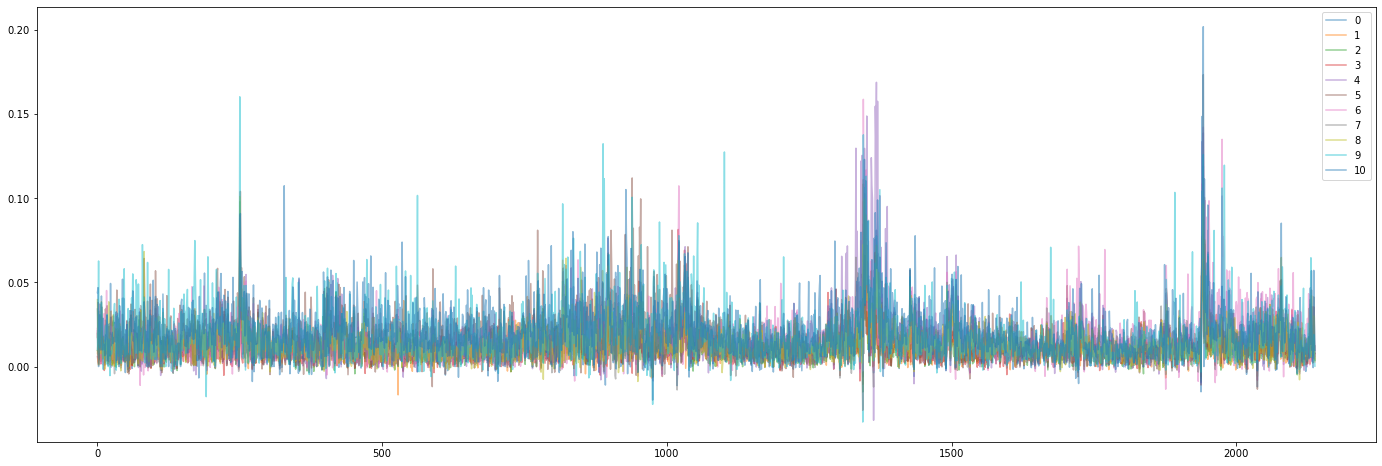

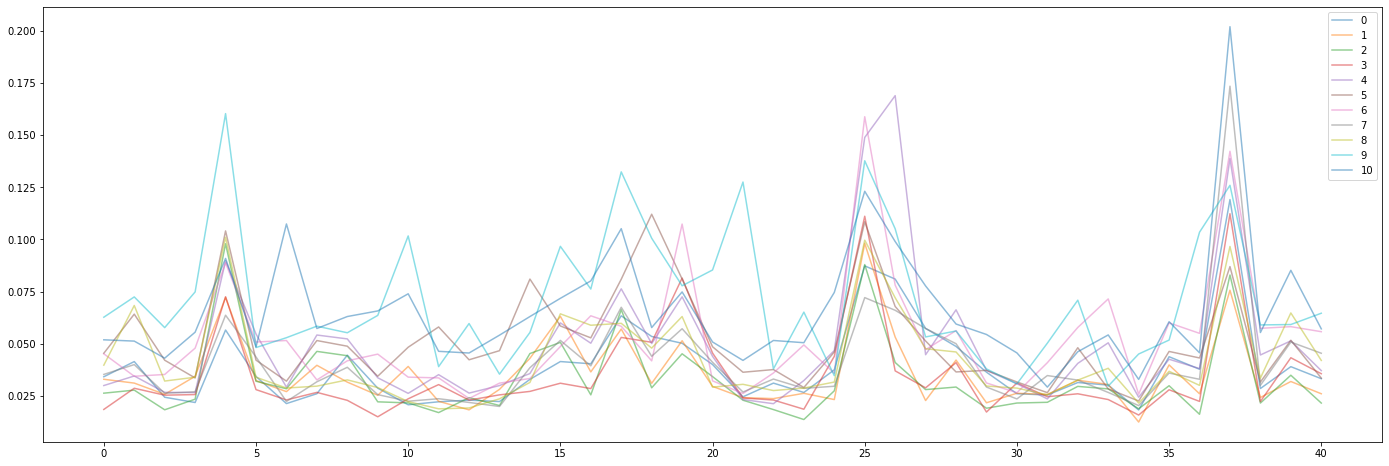

In [7]:
file = open('weekly_max_return_data.p', 'rb')
weekly_base_data = pickle.load(file)
file.close()
weekly_base_data_df = pd.DataFrame(weekly_base_data)
weekly_base_data_df.plot(figsize=(24,8), alpha = 0.5)
plt.show()

file = open('yearly_max_return_data.p', 'rb')
yearly_base_data = pickle.load(file)
file.close()
yearly_base_data_df = pd.DataFrame(yearly_base_data)
yearly_base_data_df.plot(figsize=(24,8), alpha = 0.5)
plt.show()

In [5]:
file = open('weekly_max_return_data.p', 'rb')
weekly_base_data = pickle.load(file)
file.close()

2139

In [3]:
eps = 100
evd, unc, evd_sm = True, True, True
fill = True
n_data = weekly_base_data.shape[0]

true_key = 'true_risk'
pop_key  = 'p0_risk'
adv_key  = 'adv_risk'

evd_file = "yearly_max_return_data_evd_cvar-min_gen_eps{}_data10_blocksize0/stats{}_{}.p".format(eps, eps, n_data)
evd_sm_file = "yearly_max_return_data_evd-sm_cvar-min_gen_eps{}_data10_blocksize0/stats{}_{}.p".format(eps, eps, n_data)
unc_file = "yearly_max_return_data_unc_cvar-min_gen_eps{}_data10_blocksize0/stats{}_{}.p".format(eps,eps, n_data )

5.0


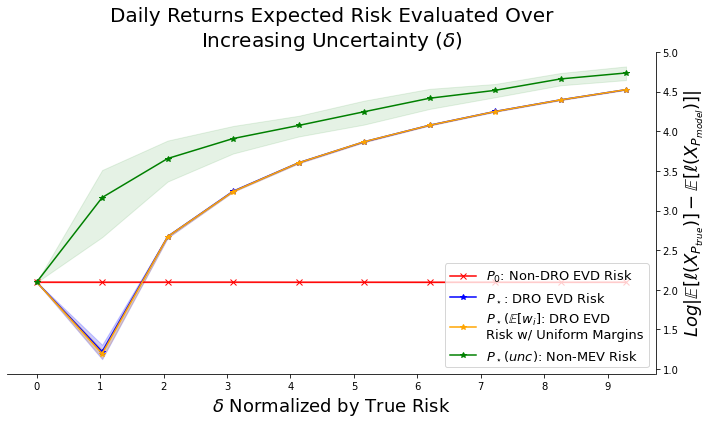

In [4]:
####LOAD EVD DATA#######
if evd:
    evd_load = open(evd_file, 'rb')
    data = pickle.load(evd_load)
    evd_load.close()
    
    true_evd = data[true_key]
    pop_evd  = data[pop_key]
    adv  = data[adv_key]
    adv = adv * (adv < 1e3)
    x = np.stack(data['losses'])[:,0]
    x_domain_evd = (x / true_evd.mean(-1))
#########################

# ####LOAD UNC DATA#######
if unc:
    unc_load = open(unc_file, 'rb')
    datau = pickle.load(unc_load)
    unc_load.close()

    true_unc = datau[true_key]
    pop_unc  = datau[pop_key]
    advu = datau[adv_key]
    advu = advu * (advu.abs() < 1e3)
    x_unc = np.stack(datau['losses'])[:,0]
    x_domain_unc = (x_unc / true_unc.mean(-1))
    x_domain_max = np.around(torch.max(x_unc / true_unc.mean(-1)).detach().numpy())
    x_ticks = np.arange(x_domain_max + 1, dtype=int)
# #########################

# ####LOAD EVD-SM DATA#######
if evd_sm:
    evd_sm_load = open(evd_sm_file, 'rb')
    datasm = pickle.load(evd_sm_load)
    evd_sm_load.close()
    
    true_sm = datasm[true_key]
    pop_sm  = datasm[pop_key]
    advsm = datasm[adv_key]
    advsm = advsm * (advsm < 1e3)
    x_sm = np.stack(datasm['losses'])[:,0]
    x_domain_sm = (x_sm / true_unc.mean(-1))
    x_domain_max = np.around(torch.max(x_sm / true_sm.mean(-1)).detach().numpy())
    x_ticks = np.arange(x_domain_max + 1, dtype=int)
# #########################

start_domain = 0

fig, ax = plt.subplots(figsize=(10,6))

error_P0 = torch.abs(pop_evd - true_evd)
error_P0_lower = np.nanmean(np.log(error_P0), -1) - np.nanstd(np.log(error_P0), -1)
error_P0_upper = np.nanmean(np.log(error_P0), -1) + np.nanstd(np.log(error_P0), -1)
ax.plot(x_domain_evd, np.nanmean(np.log(error_P0), -1), color = "red", marker ='x', label=r'$P_0$: Non-DRO EVD Risk')
if fill:
    ax.fill_between(x_domain_evd, error_P0_lower, error_P0_upper, color = "red", alpha=0.3)

#####PLOT EVD#######

if evd:
    error_Pstar = adv - true_evd
    error_Pstar[0] = error_P0[0]
    error_Pstar_lower = np.nanmean(np.log(error_Pstar), -1) - np.nanstd(np.log(error_Pstar), -1)
    error_Pstar_upper = np.nanmean(np.log(error_Pstar), -1) + np.nanstd(np.log(error_Pstar), -1)
    ax.plot(x_domain_evd, np.log(np.nanmean(error_Pstar, -1)), color = "blue", marker ='*', label=r'$P_\star$: DRO EVD Risk')
    if fill:
        ax.fill_between(x_domain_evd, error_Pstar_lower, error_Pstar_upper, color = "blue", alpha=0.2)
#####################

#####PLOT EVD-SM#####
if evd_sm:
    error_PstarUni = advsm - true_sm
    error_PstarUni[0] = error_P0[0]
    error_PstarUni_lower = np.nanmean(np.log(error_PstarUni), -1) - np.nanstd(np.log(error_PstarUni), -1)
    error_PstarUni_upper = np.nanmean(np.log(error_PstarUni), -1) + np.nanstd(np.log(error_PstarUni), -1)
    ax.plot(x_domain_sm, np.log(np.nanmean(error_PstarUni, -1)), color = "orange", marker ='*', label='$P_\star (\mathbb{E}[w_i] \approx \frac{1}{d})$: DRO EVD\nRisk w/ Uniform Margins')
    if fill:
        ax.fill_between(x_domain_sm, error_PstarUni_lower, error_PstarUni_upper, color = "orange", alpha=0.2)
#####################

#####PLOT UNC#####
if unc:
    error_Punc = advu - true_unc
    error_Punc[0] = error_P0[0]
    error_Punc_lower = np.nanmean(np.log(error_Punc), -1) - np.nanstd(np.log(error_Punc), -1)
    error_Punc_upper = np.nanmean(np.log(error_Punc), -1) + np.nanstd(np.log(error_Punc), -1)
    ax.plot(x_domain_unc, np.log(np.nanmean(error_Punc, -1)), color = "green", marker ='*', label=r'$P_\star (unc)$: Non-MEV Risk')
    if fill:
        ax.fill_between(x_domain_unc, error_Punc_lower, error_Punc_upper, color = "green", alpha=0.1)
#####################


y_domain_max = np.around(np.max(np.log(np.nanmean(error_Pstar, -1))))
print(y_domain_max)
y_ticks = np.arange(y_domain_max + 1, dtype=int)
ax.spines['top'].set_color('none')
ax.spines['right'].set_position(('axes', 1.0))
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_position(('axes', 0.0))
plt.xticks(x_ticks)
ax.yaxis.tick_right()
plt.xlabel(r'$\delta$ Normalized by True Risk', fontsize = 18)
ax.yaxis.set_label_position("right")
plt.ylabel(r'$Log \vert \mathbb{E}[\ell(X_{P_{true}})] - \mathbb{E}[\ell(X_{P_{model}})] \vert$', fontsize = 18)
plt.title("Daily Returns Expected Risk Evaluated Over\nIncreasing Uncertainty ($\delta$)", fontsize = 20)
plt.legend(loc= "lower right", fontsize = 13)
plt.tight_layout()
plt.savefig("baseline.png")